In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point
from tqdm import tqdm
from haversine import haversine, Unit
from sklearn.neighbors import BallTree

# Finding colocations between the sPlotOpen and SatBird datasets

In [ ]:
# Loading SatBird dataset
season = "summer"

# Paths to data
train_path = f"../satbird/USA_{season}/train_split.csv"
val_path = f"../satbird/USA_{season}/valid_split.csv"
test_path = f"../satbird/USA_{season}/test_split.csv"

train = pd.read_csv(train_path)
val = pd.read_csv(val_path)
test = pd.read_csv(test_path)

# Merge all splits into one dataframe
satbird_df = pd.concat([train, val, test], keys=["train", "val", "test"])
satbird_df['split'] = satbird_df.index.get_level_values(0)
satbird_df.reset_index(drop=True, inplace=True)

satbird_df = satbird_df[["hotspot_id", "lon", "lat", "split"]]

In [ ]:
# Loading sPlotOpen dataset
data_path = "../sPlotOpen/location_data.csv"
sPlot_df = pd.read_csv(data_path, index_col=0)
sPlot_df

In [ ]:
class KNN:
    """
    KNN based on BallTree, used for clustering the data points
    """
    def __init__(self, k=5):
        self.k = k
        self.RADIUS_EARTH = 6356.7523  # in km, polar radius of Earth

    def fit(self, X):
        self.X_train = X
        self.tree = BallTree(np.deg2rad(X), metric='haversine')

    def haversine_distance(self, x1, x2):
        return haversine((x1[0], x1[1]), (x2[0], x2[1]), unit=Unit.KILOMETERS)

    def predict_slow(self, X):
        dist, index = [], []
        for x in tqdm(X):
            d, i = self._predict_single(x)
            dist.append(d)
            index.append(i)
        return np.array(dist), np.array(index)
    
    def predict(self, X):
        dist, index = self.tree.query(np.deg2rad(X), k=self.k)
        dist = dist * self.RADIUS_EARTH
        return dist, index

    def _predict_single(self, x):
        # Compute distances between x and all examples in the training set
        distances = [self.haversine_distance(x, x_train) for x_train in self.X_train]
        # Get indices of k nearest neighbors
        return min(distances), np.argmin(distances)

In [ ]:
def get_collocated(dataset_A, dataset_B):
    """Find the closest points in dataset_B for each point in dataset_A using KNN."""
    
    knn = KNN(k=1)
    
    knn.fit(dataset_A)
    
    distances, indices = knn.predict(dataset_B)
    
    return distances, indices

In [ ]:
distances, indices = get_collocated(sPlot_df[["Latitude", "Longitude"]].to_numpy(), satbird_df[["lat","lon"]].to_numpy())

satbird_df['sPlot_plot'] = sPlot_df.iloc[indices.flatten()]['PlotObservationID'].values
satbird_df['distance'] = distances

# kilometer threshold for distance
# km_threshold = 0.25
km_threshold = 1

filtered_satbird_df = satbird_df[satbird_df.distance < km_threshold].reset_index()
filtered_satbird_df.to_csv("colocations_satbird_splot.csv")

In [3]:
filtered_satbird_df = pd.read_csv("colocations_satbird_splot.csv")

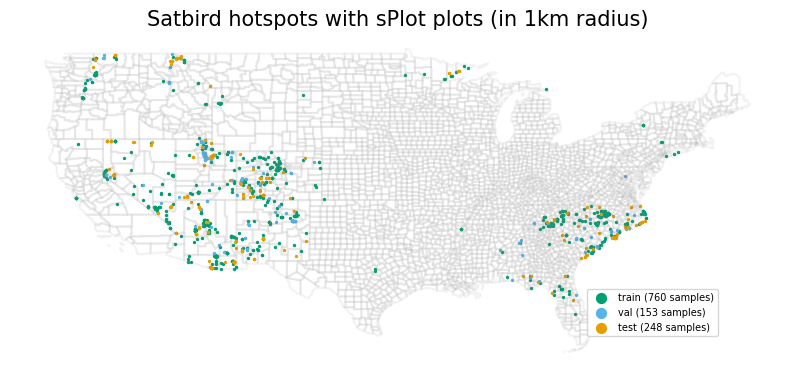

In [4]:
geoDatav = gpd.read_file('https://raw.githubusercontent.com/holtzy/The-Python-Graph-Gallery/master/static/data/US-counties.geojson')

geometry = [Point(xy) for xy in zip(filtered_satbird_df['lon'], filtered_satbird_df['lat'])]
gdf = gpd.GeoDataFrame(filtered_satbird_df, geometry=geometry)

fig, ax = plt.subplots(figsize =(10,6))

geoDatav[~geoDatav["STATE"].isin(["02", "15", "72"])].boundary.plot(ax=ax, alpha = 0.1, edgecolor = "gray" )
gdf[gdf["split"]=="train"].plot(ax=ax,marker='o', color='#009E73', markersize=2, label = f"train ({filtered_satbird_df['split'].value_counts()['train']} samples)")
gdf[gdf["split"]=="val"].plot(ax=ax, marker='o', color='#56B4E9', markersize=2, label = f"val ({filtered_satbird_df['split'].value_counts()['val']} samples)")
gdf[gdf["split"]=="test"].plot(ax=ax, marker='o', color='#E69F00', markersize=2, label = f"test ({filtered_satbird_df['split'].value_counts()['test']} samples)")

plt.legend(fontsize=7, markerscale=5,  bbox_to_anchor=(0.92, 0.25))
plt.title(f"Satbird hotspots with sPlot plots (in 1km radius)", fontsize = 15)
plt.axis('off')
plt.show()

# Adapting the format

Once colocations have been found between SatBird and sPlotOpen,the goal is to create a csv file in the same format as what is done for the SatBirdxSatButterfly task, where we have the following information: 
- hotspot ID (if in SatBird)
- sPlot_plot ID (if the location is in sPlots)
- location (lat, lon)
- other hotspot metadata
- bioclimatic variables values
- soil variables values
- 2 indicator columns: "bird" and "plant" which indicate whether data is available for birds and/or plants at each location. 
- split

Additionally, we filter sPlotOpen data to observations in the continental USA as this is where the SatBird-USA-summer is defined. 

#### Open colocation files, satbird and sPlots locations files. 

In [ ]:
colocations = pd.read_csv("/data/SatBirdxsPlots/colocations_satbird_splot.csv")

In [ ]:
satbird = pd.read_csv("/data/SatBird_data_v2/USA_summer/all_summer_hotspots_final.csv")

In [ ]:
satbird = satbird.drop(columns=["Unnamed: 0.2", "Unnamed: 0.1", "Unnamed: 0"])

In [ ]:
satbird["bird"] = 1

In [ ]:
coloc = colocations[["hotspot_id", "sPlot_plot"]]

In [ ]:
coloc["plant"] = 1

In [ ]:
satbird = satbird.merge(coloc, how = "outer", left_on = "hotspot_id", right_on="hotspot_id")

In [ ]:
satbird["plant"] = satbird["plant"].fillna(0).astype(int)

In [ ]:
splots = pd.read_csv("/data/sPlotOpen/location_data.csv")

#### Restrict sPlotOpen to the continental USA

In [2]:
from shapely.geometry import Point, MultiPolygon, Polygon
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np

In [3]:
#Find continental USA boundaries

# Load the continental U.S. boundary shapefile
# You can get this shapefile from Natural Earth or similar resources
gdf = gpd.read_file("/data/US_boundaries/cb_2018_us_nation_5m.shp")

multi_poly = gdf["geometry"][0]

polygons = list(multi_poly.geoms)

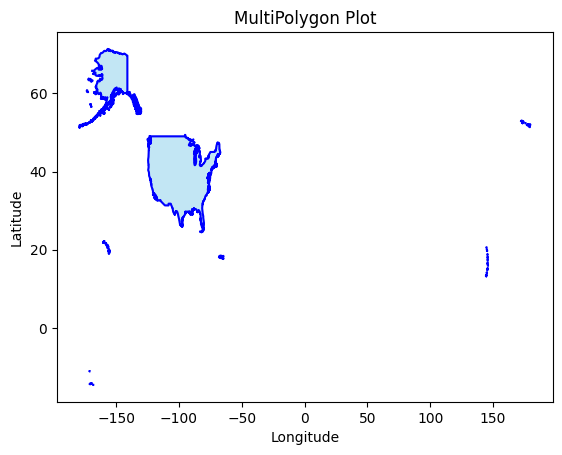

In [6]:
# Plot the MultiPolygon
fig, ax = plt.subplots()
for polygon in polygons:
    x, y = polygon.exterior.xy  # Get the exterior coordinates of each polygon
    ax.plot(x, y, color='blue')
    ax.fill(x, y, color='skyblue', alpha=0.5)  # Fill the polygon with transparency

ax.set_title("MultiPolygon Plot")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

In [ ]:
#get the part of the USA that is the continental USA by getting the largest polygon in the US boundary
continental_us = polygons[np.argmax([p.area for p in polygons])]

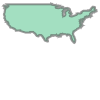

In [8]:
continental_us

#### Filter sPlotOpen by location (lat-lon)

In [ ]:
def is_in_us(latitude, longitude):
    point = Point(longitude, latitude)
    return continental_us.contains(point)
def custom_operation(row):
    return (is_in_us(row["Latitude"], row["Longitude"]))

splots["USA"] = splots.apply(custom_operation, axis = 1)

splots_usa = splots[splots["USA"]]

In [17]:
#### add sPlot locations that are not colocated with SatBird hotspots in the training set

In [ ]:
plant_only = splots_usa[~splots_usa["PlotObservationID"].isin(colocations["sPlot_plot"])]

plant_only["bird"] = 0

plant_only = plant_only.rename(columns = {"Latitude":"lat", "Longitude":"lon", "PlotObservationID": "sPlot_plot"})

plant_only["split"] = "train"

#### Add environmental data data

In [ ]:
bioclim = pd.read_csv("/data/sPlotOpen/worldclim_data.csv")

In [ ]:
soilgrids = pd.read_csv("/data/sPlotOpen/soilgrid_data.csv")

In [ ]:
bioclim.columns = bioclim.columns.str.lower()
bioclim = bioclim.rename(columns = {"plotobservationid": "sPlot_plot"})
soilgrids.columns =soilgrids.columns.str.lower()
soilgrids = soilgrids.rename(columns = {"plotobservationid": "sPlot_plot"})


In [ ]:
merged_plants= plant_only.merge(soilgrids, left_on = "sPlot_plot", right_on = "sPlot_plot")

In [ ]:
merged_plants= merged_plants.merge(bioclim, left_on = "sPlot_plot", right_on = "sPlot_plot")

In [ ]:
merged_plants = merged_plants.drop(columns = ["Unnamed: 0", "unnamed: 0_x"])

In [ ]:
merged = satbird.merge(merged_plants, how = "outer")

In [ ]:
merged = merged.drop(columns = ["unnamed: 0_y", "USA"])

In [ ]:
merged.to_csv("/data/SatBirdxsPlots/satbird_splots.csv")

#### save splits

In [ ]:
train = merged[merged["split"]=="train"]
valid = merged[merged["split"]=="valid"]
test = merged[merged["split"]=="test"]

In [ ]:
coloc_test = test[test["bird"]==1]
coloc_test = coloc_test[coloc_test["plant"]==1]

In [ ]:
coloc_test.to_csv("/data/SatBirdxsPlots/satbird_splots_test_split.csv")

In [ ]:
coloc_valid = valid[valid["bird"]==1]
coloc_valid = coloc_valid[coloc_valid["plant"]==1]

In [ ]:
#validation split that only has colocations
coloc_valid.to_csv("/data/SatBirdxsPlots/satbird_splots_valid_split_coloc.csv")

In [ ]:
#validation split that also has bird observations locations that are not co-located with sPlotOpen
valid.to_csv("/data/SatBirdxsPlots/satbird_splots_valid_split.csv")

In [ ]:
len(coloc_valid), len(coloc_test), len(valid)

In [ ]:
train.to_csv("/data/SatBirdxsPlots/satbird_splots_train_split.csv")

# SatBirdxsPlot utils: targets for splot in US only

In [ ]:
import pickle

def write_splot_targets_as_pickle(species_indices,
                                  output_file_path,
                                  targets_file="merged_species_occurrences_v2.npy",
                                  splot_location_data_file="location_data.csv"):
    """
    save splots targets as pkl to co-train with SatBird
    given splot species indices to be considered
    """
    targets = np.load(targets_file).astype(int)

    targets = targets[:, species_indices]

    loc = pd.read_csv(splot_location_data_file)
    plot_observations = loc["PlotObservationID"].astype(int).to_list()
    print(len(plot_observations))
    print(targets.shape)
    d = {}
    for i, obs_id in enumerate(plot_observations):
        d[obs_id] = targets[i]

    with open(output_file_path, 'wb') as output_file:
        pickle.dump(d, output_file)

In [ ]:
def filter_species_based_on_occurrences(species_occ_file,
                                        species_indices = None,
                                        data_indices = None,
                                        threshold = 1):
    """
    filter species occurrences based on occurrences threshold
    """
    
    species_occ = np.load(species_occ_file).astype(int)
    if species_indices:
        species_occ = species_occ[:, species_indices]
    if data_indices:
        species_occ = species_occ[data_indices, :]
    result_species_indices = np.where(
        species_occ.sum(axis=0) >= threshold
    )[0]
    return result_species_indices

def filter_out_species(split_file_name : str, species_occ_file: str, all_splot_data_file_name: str,threshold = 1):
    """
    filters out splot species based on csv data
    """
    all_data_hotspots = pd.read_csv(split_file_name)
    all_data_hotspots = all_data_hotspots[all_data_hotspots["plant"] == 1]
    ids = all_data_hotspots["PlotObservationID"].astype(int).to_list()
    
    main_splot_data = pd.read_csv(all_splot_data_file_name)
    custom_indices = main_splot_data.index[main_splot_data["PlotObservationID"].astype(int).isin(ids)].tolist()
    species_indices = filter_species_based_on_occurrences(species_occ_file = species_occ_file,
                                                          data_indices = custom_indices,
                                                          threshold = threshold)

    return species_indices

In [ ]:
splot_US_only_present_species = filter_out_species(split_file_name="../data/satbirdxsplotopen/all_splits.csv",
                                                   species_occ_file = "../data/sPlotOpen/merged_species_occurrences_v2.npy",
                                                   all_splot_data_file_name = "../data/sPlotOpen/location_data.csv",
                                                   threshold = 100)

np.save("/data/satbirdxsplotopen/plant_US_species_indices.npy", splot_US_only_present_species)

write_splot_targets_as_pickle(targets_file="../data/sPlotOpen/merged_species_occurrences_v2.npy",
                              species_indices=splot_US_only_present_species,
                              output_file_path="../data/sPlotOpen/sPlotOpen_targets_US_only.pkl",
                              splot_location_data_file="../data/sPlotOpen/location_data.csv")

In [ ]:
from numpy import sort
import pickle
import pandas as pd
import numpy as np

def get_non_zero_indices(data_split, targets):
    """
    This is for validation and test in the setup: satbirdxsplots
    :param data_split: 
    :return: 
    """
    observations = []
    for plot_id in data_split['PlotObservationID'].tolist():
        target = targets.get(int(plot_id))
        observations.append(target)
    observations = np.array(observations)
    print(observations.shape)
    non_zero_indices = observations.sum(0) != 0
    num_classes = int(non_zero_indices.sum(0))
    print(num_classes)
    non_zero_indices = np.nonzero(observations.sum(axis=0))[0]
    return non_zero_indices

data_split = pd.read_csv("/data/satbirdxsplotopen/valid_split.csv")
with open("/data/sPlotOpen/sPlotOpen_targets_US_only.pkl", "rb") as pickle_file:
    targets = pickle.load(pickle_file)

non_zero_indices = get_non_zero_indices(data_split=data_split, targets = targets)
np.save('/data/satbirdxsplotopen/plant_validation_species_indices_US_only.npy', non_zero_indices)